# Analýza uživatelů ecommerce pro doporučování produktů
#### Autor: Matěj Foukal

## Původ a struktura dat
Data byla nashromážděna v průběhu 2 měsíců zakladateli startupové společnosti. Byla shromážděna pro účely výzkumu a implementace personalizačních strategií v ecommerce. Celý dataset je veřejně dostupný na stránkách [kaggle.com](https://www.kaggle.com/datasets/kartikeybartwal/ecommerce-product-recommendation-collaborative/data). Na datech si vyzkoušíme různé techniky vizualizace dat, testování hypotéz a lineární regresi.

In [120]:
# Naimportujeme potřebné knihovny
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Příprava dat a deskriptivní statistiky proměnných
Pro lepší porozumění dat, která máme k dispozici, je nejprve popíšeme pomocí statistik dostupných proměnných. Pro lepší porozumění toho, kdo jsou naši uživatelé, vizualizujeme jejich demografické údaje. Podíváme se na souvislost mezi věkem a příjmy našich uživatelů.

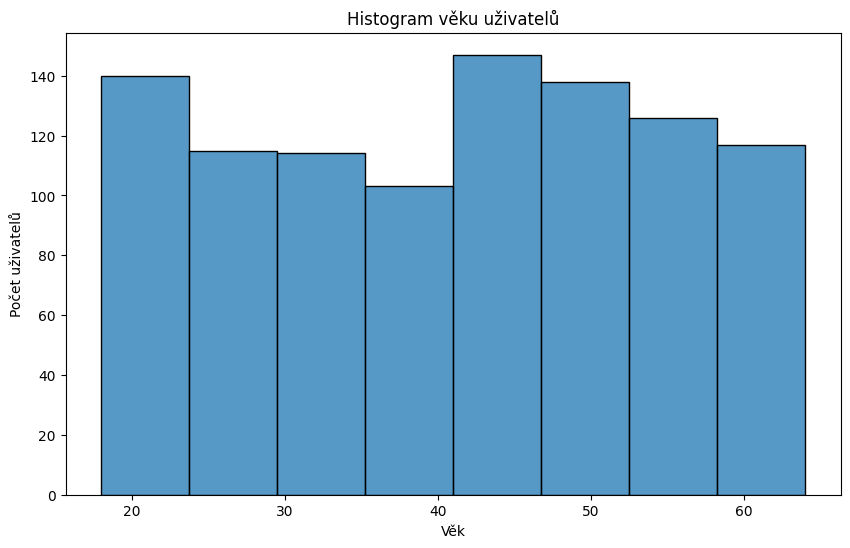

In [121]:
# Načtení dat
data = pd.read_csv("user_personalized_features.csv")

# Zobrazení dat pro věk uživatelů - klasický histogram s 8 biny
plt.figure(figsize=(10, 6))
sns.histplot(data["Age"], bins=8, kde=False)
plt.title("Histogram věku uživatelů")
plt.xlabel("Věk")
plt.ylabel("Počet uživatelů")
plt.show()

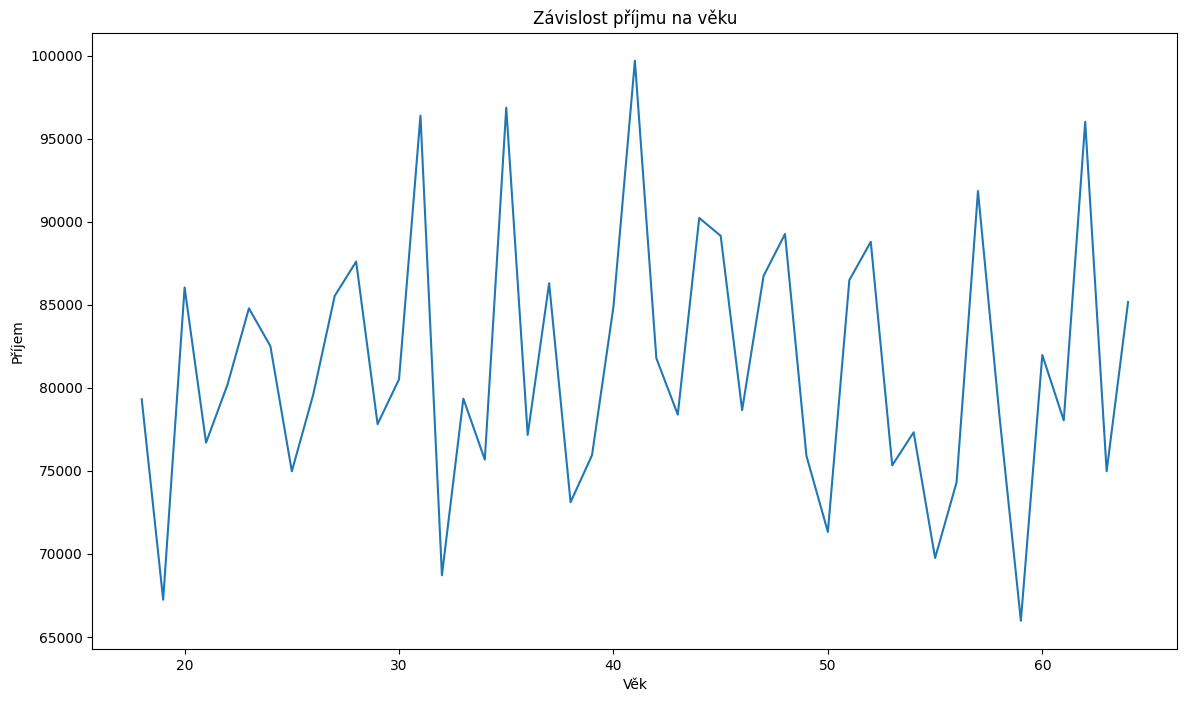

In [122]:
# Souvislost mezi věkem a příjmem
plt.figure(figsize=(14, 8))
sns.lineplot(x="Age", y="Income", data=data, errorbar=None)
plt.title("Závislost příjmu na věku")
plt.xlabel("Věk")
plt.ylabel("Příjem")
plt.show()

## Korelace
### 1.  Zjistíme, zda uživatelé, kteří nakupují častěji (Purchase_Frequency), mají nižší nebo vyšší průměrnou hodnotu objednávky (Average_Order_Value).
Tímto testem budeme sledujeme, zda existuje korelace mezi frekvencí nákupů a průměrnou hodnotou nákupu uživatele.

Korelace mezi frekvencí nákupů a průměrnou hodnotou objednávky: -0.03 (p-hodnota: 3.68e-01)


<Figure size 1000x600 with 0 Axes>

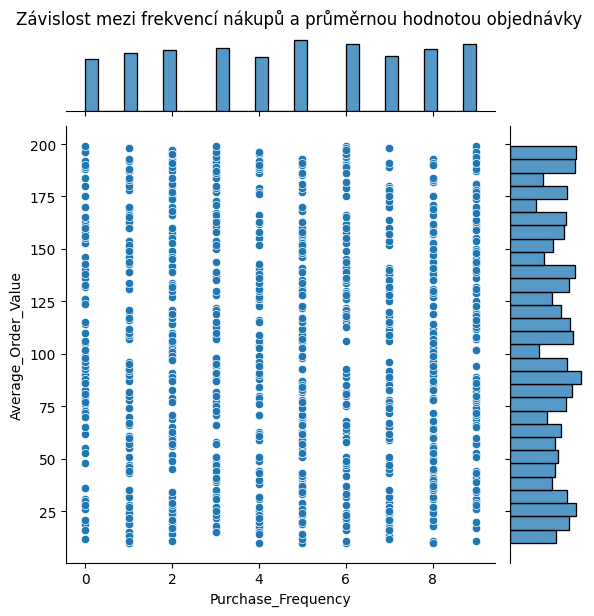

In [123]:
# 1. Korelace mezi frekvencí nákupů a průměrnou hodnotou objednávky
corr_freq_order_value, p_value_freq_order_value = stats.pearsonr(
    data["Purchase_Frequency"], data["Average_Order_Value"]
)
print(
    f"Korelace mezi frekvencí nákupů a průměrnou hodnotou objednávky: {corr_freq_order_value:.2f} (p-hodnota: {p_value_freq_order_value:.2e})"
)

# Vizualizace závislosti s hexbin plotem
plt.figure(figsize=(10, 6))
sns.jointplot(
    x="Purchase_Frequency",
    y="Average_Order_Value",
    data=data,
    kind="scatter",
    marginal_kws=dict(bins=30, fill=True),
)
plt.suptitle("Závislost mezi frekvencí nákupů a průměrnou hodnotou objednávky", y=1.02)
plt.show()

### 2. Zjistíme, zda vyšší příjem (Income) souvisí s vyššími celkovými výdaji (Total_Spending).

Korelace mezi příjmem a celkovými výdaji: -0.08 (p-hodnota: 7.49e-03)


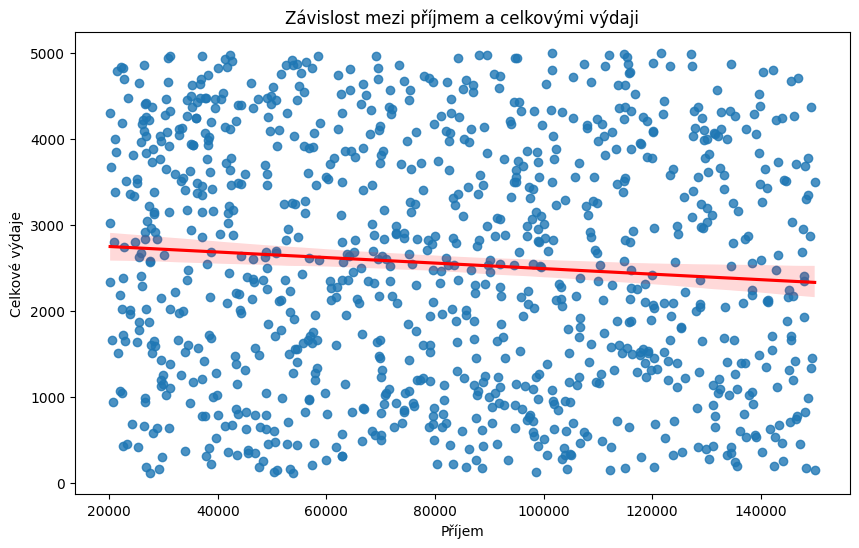

In [124]:
# 2. Korelace mezi příjmem a celkovými výdaji
corr_income_spending, p_value_income_spending = stats.pearsonr(
    data["Income"], data["Total_Spending"]
)
print(
    f"Korelace mezi příjmem a celkovými výdaji: {corr_income_spending:.2f} (p-hodnota: {p_value_income_spending:.2e})"
)

# Vizualizace závislosti s regresní přímkou
plt.figure(figsize=(10, 6))
sns.regplot(x="Income", y="Total_Spending", data=data, line_kws={"color": "red"})
plt.title("Závislost mezi příjmem a celkovými výdaji")
plt.xlabel("Příjem")
plt.ylabel("Celkové výdaje")
plt.show()

## Testování hypotéz
Otestujeme následující dvě hypotézy:
1. ### Vliv lokality uživatelů (suburban, rural, urban) na hodnotu objednávky:
   - Nulová hypotéza (H0): Průměrná hodnota objednávky je stejná pro všechny tři lokality.
   - Alternativní hypotéza (H1): Průměrná hodnota objednávky se liší mezi lokalitami.

T-test mezi Suburban a Rural: t-statistic = -0.4867, p-value = 0.6266
Nulová hypotéza (H0) pro lokality 'Suburban' a 'Rural' není zamítnuta.
T-test mezi Suburban a Urban: t-statistic = -1.1792, p-value = 0.2387
Nulová hypotéza (H0) pro lokality 'Suburban' a 'Urban' není zamítnuta.
T-test mezi Rural a Urban: t-statistic = -0.6496, p-value = 0.5162
Nulová hypotéza (H0) pro lokality 'Rural' a 'Urban' není zamítnuta.


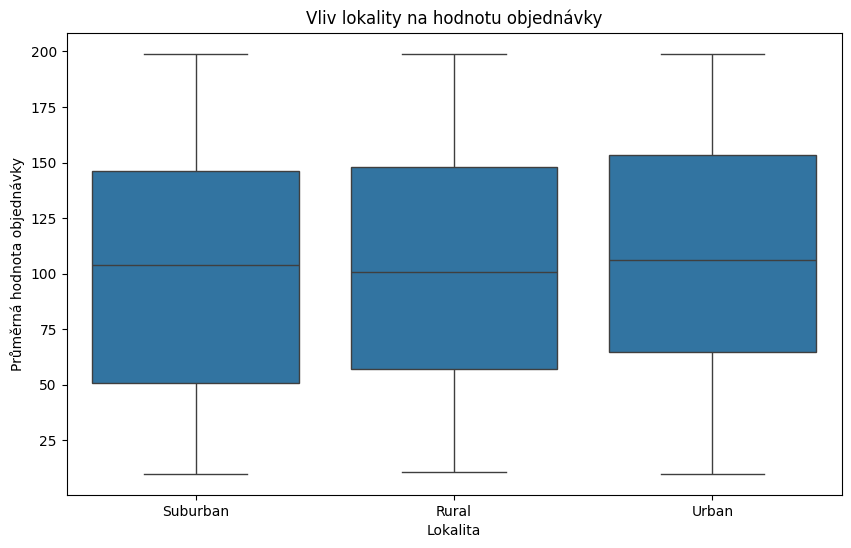

In [125]:
# Funkce pro provedení t-testu mezi dvěma lokalitami
def t_test_location(data, location1, location2):
    group1 = data[data["Location"] == location1]["Average_Order_Value"]
    group2 = data[data["Location"] == location2]["Average_Order_Value"]
    t_stat, p_value = stats.ttest_ind(group1, group2)
    return t_stat, p_value


# Párové t-testy
locations = ["Suburban", "Rural", "Urban"]
alpha = 0.05

for i in range(len(locations)):
    for j in range(i + 1, len(locations)):
        loc1, loc2 = locations[i], locations[j]
        t_stat, p_value = t_test_location(data, loc1, loc2)
        print(
            f"T-test mezi {loc1} a {loc2}: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}"
        )
        if p_value < alpha:
            print(f"Pro lokality '{loc1}' a '{loc2}' zamítáme nulovou hypotézu (H0).")
        else:
            print(
                f"Nulová hypotéza (H0) pro lokality '{loc1}' a '{loc2}' není zamítnuta."
            )

# Vizualizace
plt.figure(figsize=(10, 6))
sns.boxplot(x="Location", y="Average_Order_Value", data=data)
plt.title("Vliv lokality na hodnotu objednávky")
plt.xlabel("Lokalita")
plt.ylabel("Průměrná hodnota objednávky")
plt.show()

2. ### Vliv zájmů na frekvenci nákupů:
   - Nulová hypotéza (H0) Zájmy uživatelů nemají vliv na frekvenci nákupů.
   - Alternativní hypotéza (H1): Zájmy uživatelů mají vliv na frekvenci nákupů.

Interest: Fashion - T-test: t-statistic = -1.2852, p-value = 0.1990
Nulová hypotéza (H0) pro zájem 'Fashion' není zamítnuta.
Interest: Food - T-test: t-statistic = 0.3458, p-value = 0.7296
Nulová hypotéza (H0) pro zájem 'Food' není zamítnuta.
Interest: Sports - T-test: t-statistic = 0.0162, p-value = 0.9870
Nulová hypotéza (H0) pro zájem 'Sports' není zamítnuta.
Interest: Technology - T-test: t-statistic = 2.3143, p-value = 0.0209
Pro zájem 'Technology' zamítáme nulovou hypotézu (H0).
Interest: Travel - T-test: t-statistic = -1.3107, p-value = 0.1902
Nulová hypotéza (H0) pro zájem 'Travel' není zamítnuta.


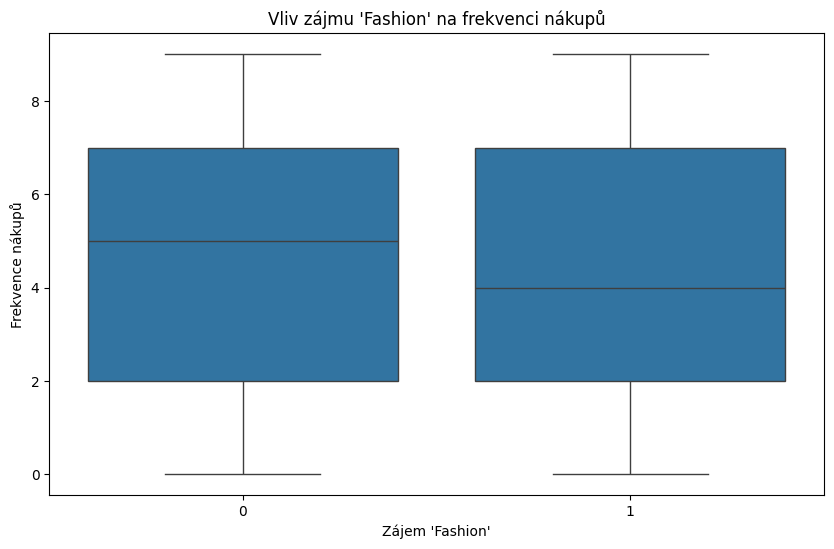

In [126]:
# Vytvoření binárních proměnných pro zájmy
interests_dummies = data["Interests"].str.get_dummies(sep=",")

# Přidáme frekvenci nákupů k binárním proměnným
interests_dummies["Purchase_Frequency"] = data["Purchase_Frequency"]


# Funkce pro provedení t-testu pro zájem
def t_test_interest(interests_dummies, interest):
    group1 = interests_dummies[interests_dummies[interest] == 1]["Purchase_Frequency"]
    group2 = interests_dummies[interests_dummies[interest] == 0]["Purchase_Frequency"]
    t_stat, p_value = stats.ttest_ind(group1, group2)
    return t_stat, p_value


# Testování hypotézy pro každý zájem
alpha = 0.05
for interest in interests_dummies.columns[:-1]:
    t_stat, p_value = t_test_interest(interests_dummies, interest)
    print(
        f"Interest: {interest} - T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}"
    )
    if p_value < alpha:
        print(f"Pro zájem '{interest}' zamítáme nulovou hypotézu (H0).")
    else:
        print(
            f"Nulová hypotéza (H0) pro zájem '{interest}' není zamítnuta."
        )


# Vizualizace pro první zájem (pouze jako příklad)
first_interest = interests_dummies.columns[0]
plt.figure(figsize=(10, 6))
sns.boxplot(
    x=interests_dummies[first_interest], y=interests_dummies["Purchase_Frequency"]
)
plt.title(f"Vliv zájmu '{first_interest}' na frekvenci nákupů")
plt.xlabel(f"Zájem '{first_interest}'")
plt.ylabel("Frekvence nákupů")
plt.show()

## Interpretace výsledků a jejich zužitkování